In [7]:
# Initial imports
import numpy as np
import pandas as pd
from stockstats import StockDataFrame as sdf
import requests
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import alpaca_trade_api as tradeapi
from pathlib import Path
import lib_copy
%matplotlib inline

In [37]:
load_dotenv()

Python-dotenv could not parse statement starting at line 7
Python-dotenv could not parse statement starting at line 8


True

In [38]:
df = lib_copy.fetch_ohlcv("TSLA", "2018-01-12", "2019-06-12")

In [39]:
def adding_boll_kelt_ewma_dataframe(dataframe):
    lib_copy.bollinger_band_generator(dataframe)
    lib_copy.keltner_channel(dataframe)
    lib_copy.ewma(dataframe)

    return dataframe

In [40]:
everything = adding_boll_kelt_ewma_dataframe(df)

In [41]:
# Looking for missing values
everything.isnull().sum().sum()

61

In [42]:
# Filling missing values with the previous ones
everything = df.dropna()

In [43]:
response_data = lib_copy.signals_generator(everything)

response_data.index = response_data.index.date
final_df = response_data

In [45]:
X = final_df.iloc[:, 0:20].values
y = final_df.iloc[:, :1].values

X, y = np.array(X), np.array(y).reshape(-1,1)

In [46]:
print (f"X sample values:\n{X[:3]} \n")
print (f"X sample values:\n{y[:3]} \n")


X sample values:
[[3.42341000e+02 3.42341000e+02 3.41410000e+02 3.41410000e+02
  4.23600000e+03 3.39281450e+02 3.15330689e+00 3.45588064e+02
  3.32974836e+02 3.42120000e+02 9.31000000e-01 1.69407581e+00
  1.69407581e+00 3.39281450e+02 3.40975526e+02 3.37587374e+02
  3.41297157e+02 3.39800440e+02 0.00000000e+00 0.00000000e+00]
 [3.41120000e+02 3.41460000e+02 3.40610000e+02 3.40840000e+02
  6.32100000e+03 3.39533450e+02 3.06046133e+00 3.45654373e+02
  3.33412527e+02 3.41410000e+02 8.50000000e-01 1.61606473e+00
  1.61606473e+00 3.39533450e+02 3.41149515e+02 3.37917385e+02
  3.41205726e+02 3.39894945e+02 0.00000000e+00 0.00000000e+00]
 [3.40720000e+02 3.41110000e+02 3.39310000e+02 3.40790000e+02
  1.48180000e+04 3.39861450e+02 2.80284351e+00 3.45467137e+02
  3.34255763e+02 3.40840000e+02 1.80000000e+00 1.63271483e+00
  1.63271483e+00 3.39861450e+02 3.41494165e+02 3.38228735e+02
  3.41122581e+02 3.39976314e+02 0.00000000e+00 0.00000000e+00]] 

X sample values:
[[342.341]
 [341.12 ]
 [340.72

In [47]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [48]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [49]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.81013287]
  [0.78529229]
  [0.80605226]
  [0.80569023]
  [0.00484291]
  [0.81487029]
  [0.12559915]
  [0.77399023]
  [0.80549373]
  [0.80917785]
  [0.01884615]
  [0.18734026]
  [0.18734026]
  [0.81487029]
  [0.80454596]
  [0.82132416]
  [0.82385497]
  [0.82300076]
  [0.        ]
  [0.        ]]

 [[0.80413101]
  [0.78108121]
  [0.80212986]
  [0.80289031]
  [0.00728427]
  [0.81615463]
  [0.12136673]
  [0.77430372]
  [0.80772573]
  [0.80569023]
  [0.01720648]
  [0.17269584]
  [0.17269584]
  [0.81615463]
  [0.80541878]
  [0.82302385]
  [0.82339203]
  [0.823487  ]
  [0.        ]
  [0.        ]]

 [[0.8021648 ]
  [0.77940825]
  [0.79575597]
  [0.8026447 ]
  [0.01723355]
  [0.81782631]
  [0.10962305]
  [0.77341852]
  [0.81202581]
  [0.80289031]
  [0.03643725]
  [0.17582144]
  [0.17582144]
  [0.81782631]
  [0.80714772]
  [0.82462743]
  [0.82297105]
  [0.82390565]
  [0.        ]
  [0.        ]]] 

X_test sample values:
[[[0.81646898]
  [0.79331772]
  [0.81296548]
  

In [50]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [51]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [52]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [53]:
# Show the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 20, 30)            3840      
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 30)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 20, 30)            7320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 20, 30)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [54]:
# Train the model
training_history = model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

Epoch 1/10
79/79 [==============================] - 4s 53ms/step - loss: 0.0854
Epoch 2/10
79/79 [==============================] - 5s 57ms/step - loss: 0.0176
Epoch 3/10
79/79 [==============================] - 5s 62ms/step - loss: 0.0166
Epoch 4/10
79/79 [==============================] - 6s 73ms/step - loss: 0.0162
Epoch 5/10
79/79 [==============================] - 5s 59ms/step - loss: 0.0151
Epoch 6/10
79/79 [==============================] - 4s 53ms/step - loss: 0.0138
Epoch 7/10
79/79 [==============================] - 4s 52ms/step - loss: 0.0130
Epoch 8/10
79/79 [==============================] - 4s 52ms/step - loss: 0.0116
Epoch 9/10
79/79 [==============================] - 4s 51ms/step - loss: 0.0100
Epoch 10/10
79/79 [==============================] - 4s 55ms/step - loss: 0.0087


In [55]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.00205119326710701

In [57]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [58]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [70]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = final_df.index[-len(real_prices): ]) 

# Show the DataFrame's head
stocks.head()

,Actual,Predicted
2019-01-15,343.630,335.716858
2019-01-15,343.420,335.710510
2019-01-15,341.585,335.122681
2019-01-15,342.250,335.359711
2019-01-15,343.430,335.120850


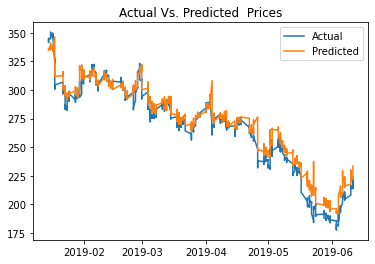

In [71]:
# Plot the real vs predicted prices as a line chart
stocks.plot(title="Actual Vs. Predicted  Prices")

In [73]:
model.evaluate(X_test, y_test)

96/96 [==============================] - 2s 23ms/step - loss: 0.0021


0.00205119326710701

In [61]:
price = pd.DataFrame(stocks)
price

,Actual,Predicted
2019-01-15,343.6300,335.716858
2019-01-15,343.4200,335.710510
2019-01-15,341.5850,335.122681
2019-01-15,342.2500,335.359711
2019-01-15,343.4300,335.120850
...,...,...
2019-06-11,217.0500,223.013962
2019-06-11,216.9200,223.228760
2019-06-11,217.0506,221.992325
2019-06-11,221.3100,226.658905


In [62]:
fast_ema = 9
slow_ema = 21

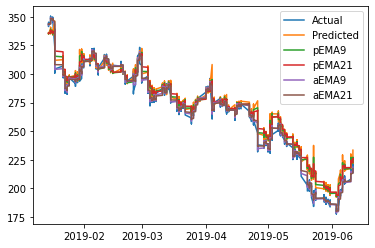

In [63]:
# create EMAs columns
price['pEMA9'] = price['Predicted'].ewm(span=fast_ema, adjust=False).mean()
price['pEMA21'] = price['Predicted'].ewm(span=slow_ema, adjust=False).mean()
price['aEMA9'] = price['Actual'].ewm(span=fast_ema, adjust=False).mean()
price['aEMA21'] = price['Actual'].ewm(span=slow_ema, adjust=False).mean()
# price['compEMAS'] = 0.0
price.plot()

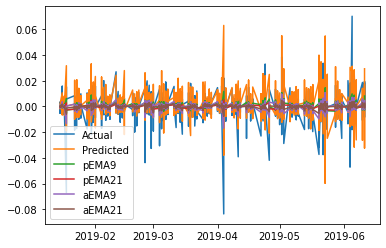

In [64]:
price.pct_change().plot()